# Comparing Natural Language Processing Approaches to Clustering Patents from Subsidiary Companies
## Peter de Guzman (ped19)
## Lilah DuBoff (lad90)
## Christian Moreira (csm87)

## Problem Statement:

Using a dataset of patents submitted to the U.S. Patent Office (USPTO) by subsidiaries of large multinational corporations, we will perform clustering of patents into patent topic categories. Some of the NLP techniques employed in this assignment include performing data cleaning on patent text, performing dimension reduction using PCA and machine learning algorithms (Complement Naive Bayes and Support Vector Classifier) for clustering patent abstracts and titles into a set of relevant comparable topics. The motivation behind this work is to address the task of tracking innovation across publicly traded companies, especially where patents are filed under different subsidiary names (i.e. “Google” with patents under “Waymo”, “DeepMind”, “Nest”); Emerging technological advancements often occur under subsidiaries of large corporations, but are not tracked due to the multitude of subsidiary firms. This project explores classification methods beyond the traditional Cooperative Patent Classification (CPC) system, offering more flexible and insightful ways for legal specialists, researchers, and investors to explore patent content and similar innovation strategies.


## Solution:

Large publicly traded companies are constantly innovating and investing millions of dollars in research and development to maintain a competitive edge in the marketplace while developing new products. The patents during the innovation process are often filed by the subsidiaries of these large companies. Informed investors and attorneys rely on alternative patent data to track the actions of these subsidiaries and better understand emerging trends and forecast growth across industries, but manually tracking patents can be resource intensive due to complex corporate structures between parent companies and subsidiaries. Oftentimes a large publicly traded company could have dozens to hundreds of subsidiaries, each filing patents under a separate entity. Targeting subsidiary companies requires name mapping solutions that can parse large amounts of patent data and establish connections between seemingly disparate corporate entities. For investors, scientists, and legal advisors it is instrumental to be able to quickly track a patent for a company while also evaluating novel inventions in strategic areas of the industries in which they operate. 

To address this, we tested the ability of two models that cluster patent text content (title and abstracts) into meaningful groups by topic. For cluster evaluation we compare model clusters to IPC Sections and Classes (see Exhibit 1 for an example of this). The models implemented in this experiment use two supervised techniques: a Complement Naive Bayes classifier and a support vector classifier (SVC) model. Both models were trained on a dataset of patent documents and evaluated using standard clustering metrics such as accuracy, predictions, and recall. Before classification the data was preprocessed to remove distracting terms (filler words) or combine terms together (plural nouns i.e. box & boxes). The model evaluation occurs relative to its actual classification group, which is a combination of patent section and class. 

![PatentTaxonomy](PatentTaxonomy.png)

![ProjectStructure](Projectstructure.png)

The Complement Naive Bayes classifier (or ComplementNB) is a supervised, probabilistic linear model modified from a multinomial Naive Bayes model. In the real patent data, classes are often highly imbalanced - some sections appear far more frequently than others. ComplementNB is designed to perform well on imbalanced text data, as it estimates feature weights for sparser classes, which reduces model bias and stabilizes predictions across different class types. It completes this by assuming conditional independence between words, and relying on frequency-based computations. The combination of these strategies makes the model robust, even on messy or imbalanced data, making it a strong choice for patent classifications.

The support vector classifier (or LinearSVC) is also a supervised machine learning model, but instead of looking at how often words appear in each class, like ComplementNB does, LinearSVC learns which combinations of words best separate one IPC section from another. For patent data, this is effective because Linear SVC can pick up on more complex and detailed language patterns in titles and abstracts. The drawback is that LinearSVC is less interpretable, takes longer to train (marginal with the amount of data we have, but important to note for scalability and cost efficiency), and doesn’t perform as well on imbalanced data when compared to ComplementNB. With balanced data, LinearSVC typically outperforms a text classifying Naive Bayes model - therefore it is important to compare both to contextualize accuracy and efficiency in patent classification.



# Evaluation of Training Results

In [160]:
# Load in libraries and data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# UPDATE: Added CountVectorizer here
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
import re
import math
from sklearn.decomposition import PCA
import warnings
from tabulate import tabulate
import numpy as np

warnings.filterwarnings("ignore")

import os

os.environ["PYTHONWARNINGS"] = "ignore::sklearn.exceptions.ConvergenceWarning"

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [161]:
# PREPROCESSING CODE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

stop = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


# makes everything lowercase, removes punctuation, lemmatizes, and removes stopwords
def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)
    t = " ".join([lemmatizer.lemmatize(word) for word in t.split() if word not in stop])
    return t


# load in new subset
df_subset = pd.read_csv("data/top500_patents.csv")

# combine section and class, then clean text
df_subset["Combined_ipc_clean"] = (
    df_subset["ipc_sections"] + "_" + df_subset["ipc_classes"].astype(str)
)

# combine title and abstract for easier classification
df_subset["text_clean"] = (
    (df_subset["patent_title"] + ": " + df_subset["patent_abstract"])
    .astype(str)
    .apply(clean_text)
)

# Additional Data Cleaning

# drop under 50 observations
df_subset = df_subset.groupby("Combined_ipc_clean").filter(lambda x: len(x) >= 50)

# remove the duplicate rows
dups_to_remove = ["H_4", "G_1", "B_1", "G_6", "C_7"]
for dup in dups_to_remove:
    df_subset = df_subset[df_subset["Combined_ipc_clean"] != dup]

## Generating Synthetic Data from CNB Conditional Word Distributions Learned From Real Data

**Generating Synthetic Data:**

To generate synthetic data that aligns with the assumptions made by the Complement Naive Bayes Classifier, we sampled from the CNB’s per-class multinomial word distribution. To achieve this, we trained the CNB model on our real data (patent data on the subsidiaries of large multinational firms). Then we extracted the per-class multinomial word distributions that the CNB model learned from the real data. After this, we sampled documents by sampling word counts from that distribution and converted the sampled word counts into raw text tokens. 

After generating this synthetic data, we trained new CNB and SVC models on this synthetic dataset. The results are discussed in the following two sections. 

Note: For complete summary tables for each model, please refer to the Appendix at the end of this report.


In [162]:
# train CNB on our real data so we can generate the synthetic data

# Use inputs and labels from the real dataset
X_bayes = df_subset["text_clean"]
y_bayes = df_subset["Combined_ipc_clean"]

# Perform the train-test split
X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(
    X_bayes, y_bayes, test_size=0.20, stratify=y_bayes, random_state=42
)

# Use CountVectorizer and fit the model
vec = CountVectorizer(stop_words="english")
X_train_vec = vec.fit_transform(X_train_bayes)
X_test_vec = vec.transform(X_test_bayes)

cnb = ComplementNB()
cnb.fit(X_train_vec, y_train_bayes)

# Evaluate the CNB model on real data
preds = cnb.predict(X_test_vec)
report_dict_realdata = classification_report(y_test_bayes, preds, output_dict=True)

In [163]:
# Creating a CNB-Based way to generate synthetic text from the model's learned conditional word distributions

# compute class priors from real data

class_counts = y_train_bayes.value_counts()
class_priors = class_counts / class_counts.sum()
# print("Real class priors:")
# print(class_priors)


def sample_docs_from_cnb_with_real_priors(
    cnb, vectorizer, class_priors, n_total_docs=5000, doc_len_range=(50, 120)
):

    classes = cnb.classes_
    vocab = vectorizer.get_feature_names_out()

    # normalize
    raw_probs = np.exp(cnb.feature_log_prob_)
    word_probs = raw_probs / raw_probs.sum(axis=1, keepdims=True)

    synthetic_labels = np.random.choice(
        class_priors.index, size=n_total_docs, p=class_priors.values
    )

    synthetic_texts = []

    for cls in synthetic_labels:
        # find  index (number)
        c_index = np.where(classes == cls)[0][0]

        # probability distribution for words
        p_w_given_c = word_probs[c_index]

        # sample doc len
        L = np.random.randint(*doc_len_range)

        # sample word indices
        sampled_idx = np.random.choice(len(vocab), size=L, replace=True, p=p_w_given_c)

        # convert to tokens
        doc_words = [vocab[i] for i in sampled_idx]
        synthetic_texts.append(" ".join(doc_words))

    return pd.Series(synthetic_texts), pd.Series(synthetic_labels)


# Generate the synthetic dataset
X_syn, y_syn = sample_docs_from_cnb_with_real_priors(
    cnb=cnb,
    vectorizer=vec,
    class_priors=class_priors,
    n_total_docs=10000,  # going to make a lot
    doc_len_range=(50, 120),
)

# print("Synthetic dataset size:", len(X_syn))
# print("Per-class counts:")
# print(y_syn.value_counts())

# print("Synthetic class distribution:")
# print(y_syn.value_counts(normalize=True))

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, stratify=y_syn, random_state=42
)

# Train CNB on synthetic data
cnb_synth = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english")),
        ("nb", ComplementNB()),
    ]
)
cnb_synth.fit(X_train_syn, y_train_syn)

# Train SVC on synthetic data
svc_synth = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english")),
        ("clf", LinearSVC(max_iter=5000, dual=False)),
    ]
)
svc_synth.fit(X_train_syn, y_train_syn)

Pipeline(steps=[('vec', CountVectorizer(stop_words='english')),
                ('clf', LinearSVC(dual=False, max_iter=5000))])

In [165]:
from sklearn.metrics import accuracy_score

cnb_acc = cnb_synth.score(X_test_syn, y_test_syn)
svc_acc = svc_synth.score(X_test_syn, y_test_syn)

print("Synthetic Data Performance:")
print(f"CNB accuracy: {cnb_acc:.4f}")
print(f"SVC accuracy: {svc_acc:.4f}")

Synthetic Data Performance:
CNB accuracy: 0.5030
SVC accuracy: 0.4915


**Complement Naive Bayes Classifier:**

To experiment with the ComplementNB algorithm, we generated synthetic data that aligned with the processed data from the U.S. Patent and Trademark Office (detailed below in the “Application of Solution on Real Data” section.) This synthetic dataset had random filler noise words and shared words across all classes to attempt to mimic real patents, and we introduced a randomized number of documents per class so the synthetic dataset was not uniform. We also generated the synthetic documents so that the synthetic dataset was imbalanced to match the real data. We used CountVectorizer to transform the text in the documents into feature vectors. CountVectorizer converts each document into a vector of raw word counts, where each feature represents how many times a particular word appears in the document. This approach captures the frequency of the terms but does not add any additional weighting, which occurs in methods such as TF-IDF. We initially used TF-IDF, but found that CountVectorizer is better aligned with Complement Naive Baye’s assumptions because CNB assumes that word counts follow a multinomial distribution. We discuss the pros and cons of CountVectorizer vs. TF-IDF later in this report. 

Overall, on the synthetic data the complementNB model performed poorly, achieving an accuracy score of 50.3%. The model’s weighted average was low (39%), displaying that the model performed well on high-support classes. However, this can be misleading because the model performed very poorly on small classes. The macro average F1 score was extremely low (approximately 9%), indicating that across classes the model did not perform to the same level and that when every class is weighted equally the model performed poorly. When classes had less support and were smaller, the model performed more poorly, especially when the support was under 20 observations. This is because the model’s recall was very low and the model would instead predict the majority class. The model performed well for classes “A_61” and “G_06”, which aligns with our expectations because the synthetic data is very imbalanced and dominated by these two classes. Despite using Complement Naive Bayes, which is better suited that Multinomial Naive Bayes for handling imbalanced datasets when performing text classification, our model still appears vulnerable to data sparsity as is typical for Naive Bayes. 


**Support Vector Classifier:**

The support vector classifier (SVC) was adopted using a linear kernel that optimizes decision boundaries on high dimensional feature spaces produced by CountVectorizer. CountVectorizer represents each document using raw counts of words that appear in the document. The number of patent filings among subsidiaries varies significantly due to each company's size, industry and need for patents. This results in a dataset that is very imbalanced. To address that unevenness, SVC used a balanced class weighting strategy that adjusts penalty misclassification inversely proportional to class frequencies. This allows the model to more effectively separate classes by maximizing the margin between cluster classes.

The SVC model performed slightly worse than the Complement Naive Bayes classifier on the synthetic data. This matches our expectations, because the synthetic data was generated by sampling the CNB’s multinomial distribution and met CNB’s assumptions. The overall training accuracy for the SVC model on the synthetic data was approximately 49%. The model performed well for some classes with higher numbers of support, such as “H_04”, “G_06”, and “A_61”. 

SVC did not perform well in instances where there were very few patents for a given class. This included classes such as “A_43”, “A_63”, “B_65”, and “H_01”, among others. This underperformance suggests that the scarcity of training examples in some classes prevented the model from forming a good decision boundary for this label. In this case the classifier likely exhibited a bias toward the majority classes, failing to capture granular features required to accurately identify smaller classes.


# Application of Solution on Real Data

**Summary Table of Model Results:**

In [166]:
import time
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# -----------------------------------
# 1. Data Preparation
# -----------------------------------

# Real data
X_real = df_subset["text_clean"]
y_real = df_subset["Combined_ipc_clean"]

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, stratify=y_real, random_state=42
)

# Synthetic data (assumes X_syn, y_syn already generated)
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, stratify=y_syn, random_state=42
)


def evaluate_model(model, X_train, y_train, X_test, y_test):
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    t0 = time.time()
    preds = model.predict(X_test)
    test_time = time.time() - t0

    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average="macro")

    return acc, macro_f1, train_time, test_time


vec = CountVectorizer(
    stop_words="english",
    # max_features=50000
)

vec.fit(pd.concat([X_train_real, X_train_syn]))

# Transform datasets
X_train_real_vec = vec.transform(X_train_real)
X_test_real_vec = vec.transform(X_test_real)
X_train_syn_vec = vec.transform(X_train_syn)
X_test_syn_vec = vec.transform(X_test_syn)

# train and evaluate models on the synthetic data and the real data so we can make summary table

results = []

# CNB - Real
cnbr = ComplementNB()
acc, f1, t_train, t_test = evaluate_model(
    cnbr, X_train_real_vec, y_train_real, X_test_real_vec, y_test_real
)
results.append(["REAL", "CNB", acc, f1, t_train, t_test])

# SVC--Real
svcr = LinearSVC()
acc, f1, t_train, t_test = evaluate_model(
    svcr, X_train_real_vec, y_train_real, X_test_real_vec, y_test_real
)
results.append(["REAL", "SVC", acc, f1, t_train, t_test])

# CNB - Synthetic
cnbs = ComplementNB()
acc, f1, t_train, t_test = evaluate_model(
    cnbs, X_train_syn_vec, y_train_syn, X_test_syn_vec, y_test_syn
)
results.append(["SYNTHETIC", "CNB", acc, f1, t_train, t_test])

# SVC - Synthetic
svcs = LinearSVC()
acc, f1, t_train, t_test = evaluate_model(
    svcs, X_train_syn_vec, y_train_syn, X_test_syn_vec, y_test_syn
)
results.append(["SYNTHETIC", "SVC", acc, f1, t_train, t_test])

# create the summary table

summary_df = pd.DataFrame(
    results,
    columns=[
        "Dataset",
        "Model",
        "Accuracy",
        "Macro-F1",
        "Train Time (s)",
        "Test Time (s)",
    ],
)
# round to 4 like in appendix tables
summary_df[["Accuracy", "Macro-F1", "Train Time (s)", "Test Time (s)"]] = summary_df[
    ["Accuracy", "Macro-F1", "Train Time (s)", "Test Time (s)"]
].round(4)

print("==== Summary Table for All Experiments ====")
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

==== Summary Table for All Experiments ====
+----+-----------+---------+------------+------------+------------------+-----------------+
|    | Dataset   | Model   |   Accuracy |   Macro-F1 |   Train Time (s) |   Test Time (s) |
+====+===========+=========+============+============+==================+=================+
|  0 | REAL      | CNB     |     0.6954 |     0.524  |           0.0309 |          0.0015 |
+----+-----------+---------+------------+------------+------------------+-----------------+
|  1 | REAL      | SVC     |     0.7232 |     0.6145 |           2.1687 |          0.0014 |
+----+-----------+---------+------------+------------+------------------+-----------------+
|  2 | SYNTHETIC | CNB     |     0.505  |     0.1007 |           0.0274 |          0.0019 |
+----+-----------+---------+------------+------------+------------------+-----------------+
|  3 | SYNTHETIC | SVC     |     0.4905 |     0.0981 |           0.3277 |          0.0023 |
+----+-----------+---------+--------

To conduct this experiment, we collected publicly available patent data from the U.S. Patent and Trademark Office (USPTO). First, we researched the thirty companies listed in the Dow Jones Industrial Average, a stock market index of prominent companies. Referencing this list, we collected the legal incorporated names of subsidiaries for each large company. Finally, we used this list of subsidiary names as input for the USPTO API which returned the patent title and abstract for each subsidiary company. 

We conducted multiple data pre-processing steps to clean the data and improve accuracy. First, we removed duplicate patent observations. We also combined the “class” and “section” labels for each patent to produce more meaningful clusters. Both the “class” and “section” labels identify patents by industry field and topic. We additionally subset the data to only predict classes that have more than fifty observations. As patent classifications can be very niche, we expect to observe many patents that have multiple classifications but only one or two observations. This sort of data does not typically perform well for machine learning problems, so we dropped them. 

We also performed multiple steps to make the text easier to classify. We first converted all text to lowercase and used the Python Natural Language Toolkit (“nltk”) package to remove stopwords such as “the”, “and”, etc. We also used a lemmatizer which converts all the words in our dataset to their dictionary form (a lemma). This improves the accuracy by treating words with similar meanings the same, reducing data redundancy and making the text more consistent. Finally, to quicken the training process and reduce the compute load on our machines, we reduced the dataset to the most recent 500 patents. We then created training and test splits from this smaller dataset.



**Complement Naive Bayes Classifier:**

After these preprocessing steps, the ComplementNB classifier achieved an overall accuracy of 70%. Given the 47 classes in our dataset and the imbalanced nature of patent classification, this performance exceeded our expectations. 

The macro average F1 score, which treats classes equally, was 52%. This indicates that we have imbalance issues in our dataset. The weighted F1 score, which accounts for imbalance by weighing each class by how frequent it is, was 66%. Since the weighted average is high, we can conclude that the model performed well on classes that are more common. However, the macro average was much lower, displaying that the model performs poorly on rare classes. When reviewing the classification report below, we can observe that the F1 score was consistently higher for classes with more support, or a higher number of true samples in the class. This matches our expectation that the model’s metrics are more stable for classes with more support. Poor results occurred more often for classes with support of fewer than 20 observations. 



The two figures below demonstrate the relationship between the accuracy of the model as both the synthetic and real training dataset size increases. As the training set size increases, the training accuracy drops and the validation accuracy for the model grows. This aligns with our expectations because Complement Naive Bayes is a high-bias and low-variance model like its other Naive Bayes peers. When the training data is small, the model can overfit to the word distributions. As the training dataset size increases, the model overfits less, reducing training accuracy but increasing validation accuracy because the distribution estimates improve. In particular, Complement Naive Bayes is designed to benefit from more data, and this positive growth in validation accuracy with more training data can be observed in the graphs. 



In [167]:
# Multinomial Naive Bayes Classifier
# Inputs and labels
X_bayes = df_subset["text_clean"]
y_bayes = df_subset["Combined_ipc_clean"]

X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(
    X_bayes, y_bayes, test_size=0.20, stratify=y_bayes, random_state=42
)

# Build model
# UPDATE: Swapped TF-IDF for CountVectorizer
class_model = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english")),
        ("nb", ComplementNB()),
    ]
)

# Train
class_model.fit(X_train_bayes, y_train_bayes)

# Evaluate
preds = class_model.predict(X_test_bayes)

# Compute report as dict
report_dict_realdata_cnb = classification_report(y_test_bayes, preds, output_dict=True)

# Convert to DataFrame
report_df_real_cnb = pd.DataFrame(report_dict_realdata_cnb).transpose()

# Round numbers for readability
report_df_real_cnb = report_df_real_cnb.round(4)

# print("Real Data Results (CountVectorizer):")
# print(tabulate(report_df_real_cnb, headers='keys', tablefmt='grid'))

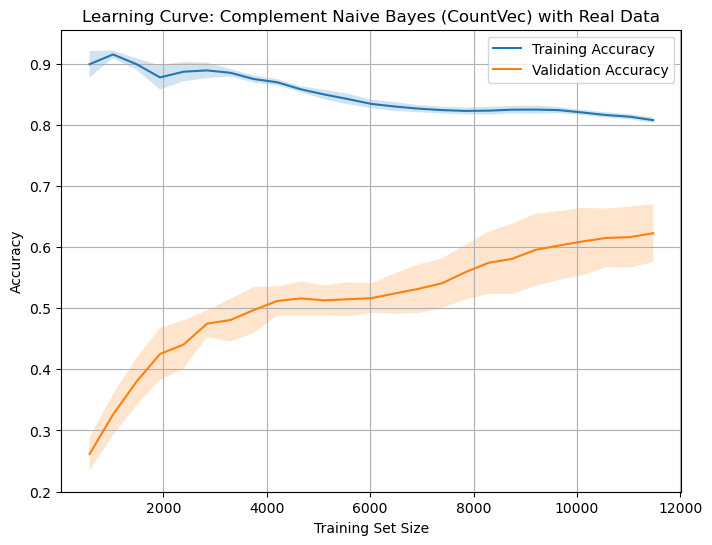

In [173]:
# Visualize the learning curve
from sklearn.model_selection import learning_curve
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# UPDATE: Ensure CountVectorizer is imported if running this cell independently
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

# The SVC had a convergence warning for the real data, but we were not able to fix it
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


def plot_learning_curve(estimator, title, X, y):
    plt.figure(figsize=(8, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=8,
        n_jobs=1,
        train_sizes=np.linspace(0.05, 1.0, 25),
        scoring="accuracy",
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")

    # Train accuracy
    plt.plot(train_sizes, train_mean, label="Training Accuracy")
    plt.fill_between(
        train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2
    )

    # Validation accuracy
    plt.plot(train_sizes, test_mean, label="Validation Accuracy")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    plt.legend()
    plt.grid(True)
    plt.show()


# Create models
# UPDATE: Swapped TF-IDF for CountVectorizer
svc_model = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english")),
        ("clf", LinearSVC(max_iter=5000, dual=False)),
    ]
)

# UPDATE: Swapped TF-IDF for CountVectorizer
cnb_model = Pipeline(
    [
        (
            "vec",
            CountVectorizer(
                stop_words="english"
                # max_features=5000
            ),
        ),
        ("nb", ComplementNB()),
    ]
)

# Plot learning curves
plot_learning_curve(
    cnb_model,
    "Learning Curve: Complement Naive Bayes (CountVec) with Real Data",
    X_bayes,
    y_bayes,
)

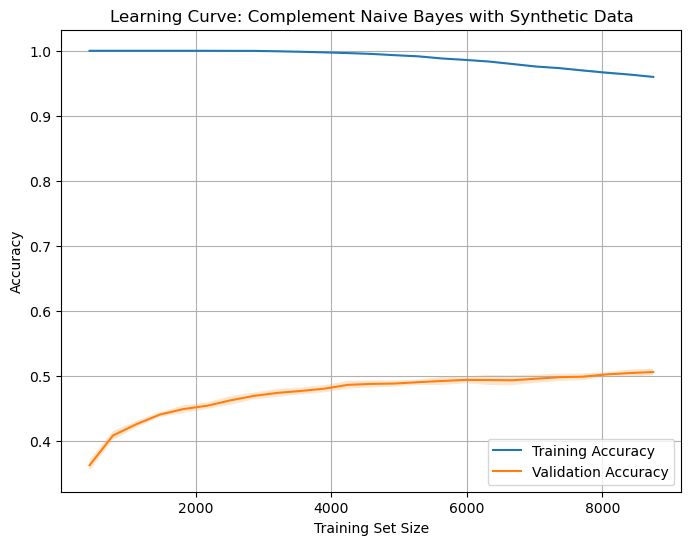

In [174]:
# Visualizing CNB with Synthetic Data
plot_learning_curve(
    cnb_synth,
    "Learning Curve: Complement Naive Bayes with Synthetic Data",
    X_syn,
    y_syn,
)

**Support Vector Classifier:**

To address the class imbalance issues previously identified, a Support Vector Classifier (SVC) was implemented utilizing CountVectorizer for feature extraction. The model was explicitly configured with balanced class weights to penalize the misclassification of minority categories. This architecture is now implemented in real world data for the 47 classes, allowing the SVC to establish decision boundaries influenced by the ground truth setting when analyzing patents.

Here accuracy was ~72% suggesting the model classifies nearly 3 out of 4 patents correctly when performing in untrained data. Macro average f1 score was .61 while on weighted average it was .73.  This divergence highlights that despite the balanced class weights, the model's predictive power remains skewed toward the majority classes where the classification of rare patent types contributes to the error rate more. 

These charts demonstrate high variance between training and validation, seen by the gap between training accuracy (~95%) and the lower validation accuracy (~58%). However, the validation curve's steady upward trajectory indicates that the model has not yet plateaued and is effectively learning, suggesting that adding more training data would likely continue to improve performance. A positive aspect is that as training data increases so does the validation accuracy performance. We recognize that there was error with the learning curve of the synthetic data - it maintained an accuracy of 100% as the size increased, showing that the model memorized the patterns it was shown. Neither increasing size nor number or iterations proved effective in reducing the overfitting, therefore we disclose it as a limitation of our approach. Our research suggests that TF-IDF is a useful solution to reduce this overfitting, but we have chosen to revise our models without it. 


In [175]:
# SVC code
# Define X and y
X_svc = df_subset["text_clean"]
y_svc = df_subset["Combined_ipc_clean"]

# Train/test split
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(
    X_svc, y_svc, test_size=0.2, stratify=y_svc, random_state=42
)

# LinearSVC model
# UPDATE: Swapped TF-IDF for CountVectorizer
svc_model_real = Pipeline(
    [
        ("vec", CountVectorizer(stop_words="english")),
        ("clf", LinearSVC(class_weight="balanced")),
    ]
)

# Fit model
svc_model_real.fit(X_train_svc, y_train_svc)

# Predictions
y_pred_svcreal = svc_model_real.predict(X_test_svc)

# Evaluation
# Compute report as dict
report_dict_realdata_svc = classification_report(
    y_test_svc, y_pred_svcreal, output_dict=True
)

# Convert to DataFrame
report_df_real_svc = pd.DataFrame(report_dict_realdata_svc).transpose()

# Round numbers for readability
report_df_real_svc = report_df_real_svc.round(4)

# print("Real Data Results - SVC (CountVectorizer):")
# print(tabulate(report_df_real_svc, headers='keys', tablefmt='grid'))

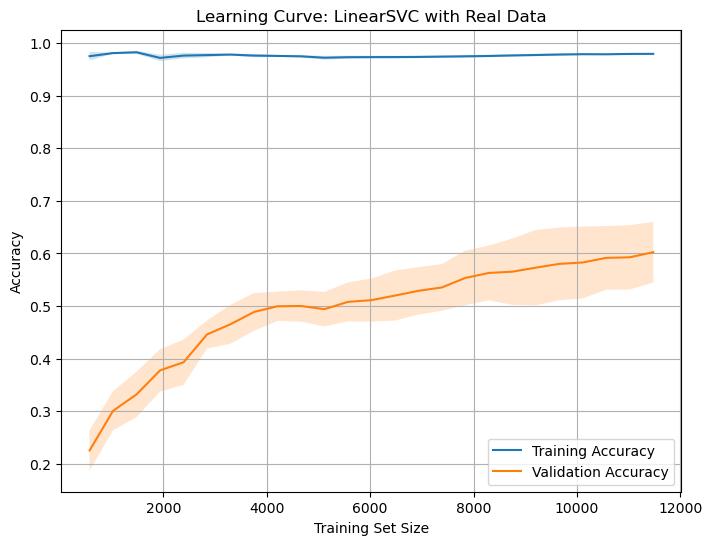

In [176]:
# Visualizing SVC
# major convergence warning here due to lack of iterations
# went as high as 500k with no change in learning curve for training accuracy
plot_learning_curve(
    svc_model_real, "Learning Curve: LinearSVC with Real Data", X_svc, y_svc
)

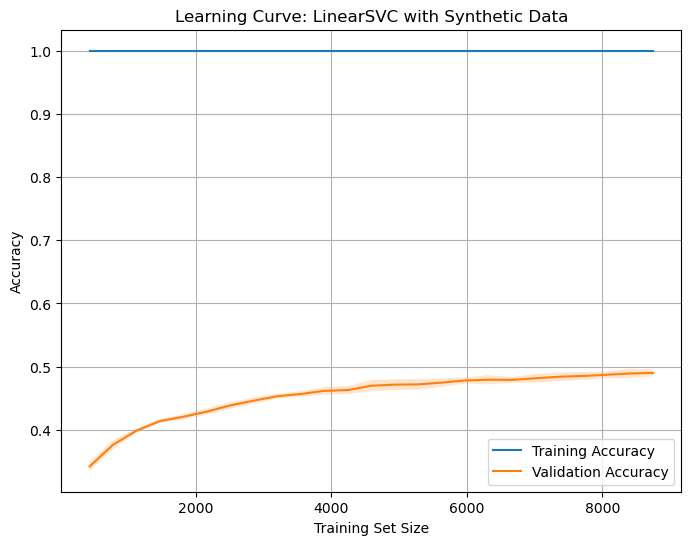

In [177]:
# Visualizing SVC with Synthetic Data
plot_learning_curve(
    svc_synth, "Learning Curve: LinearSVC with Synthetic Data", X_syn, y_syn
)

To prepare the data for clustering, the contents of the patent abstracts and titles are extracted and fed into a CountVectorizer process, which converts the text into feature vectors by counting the number of times a word appears in a document. Since a 5000-D space is difficult to picture, Principal Component Analysis (PCA) is used to find the two most important features that dictate how the data spreads out, and all data is then flattened onto that 2D plane. 

The two plots below visualize the distribution of data samples across the seven distinct IPC Sections (A, B, C, E, F, G, and H) projected onto the two Principal Components (PC1 and PC2). There is a notable disparity in sample sizes, with Section G (876 samples) and Section A (833 samples) being the most robust, while Sections E and F contain significantly fewer data points (54 and 57 points, respectively). The combined cluster plot shows a dense overlapping linear shape. The individually plotted clusters reveal that Sections C, E, and F have a linear clustering indicative of a potentially correlated and distinct technical vocabulary, whereas broader sections like G, B, and A display wider distributions that suggest more semantic diversity, or many outlier/unusual values. The overlapping clusters, combined with the imbalance data, implies that the LinearSVC may face challenges in creating clear decision boundaries or distinguishing between semantically different patent contents. 


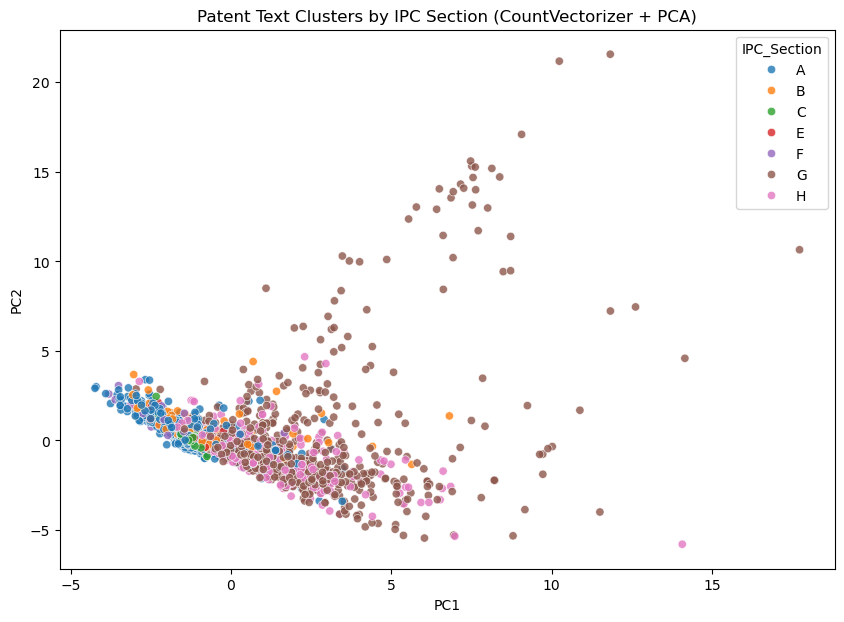

In [178]:
# Additional SVC plots
def normalize_ipc_label(label: str) -> str:
    # Handle composite labels (e.g., H;G:06) by taking the first section
    if ";" in label:
        label = label.split(";")[0]

    # Extract the IPC Section (A, B, C...)
    match = re.search(r"^[A-H]", label)  # IPC sections go from A to H
    if match:
        return match.group(0)

    return "UNKNOWN"


# Normalize the labels with the function above
y_sections = [normalize_ipc_label(lbl) for lbl in y_test_svc]


# Vectorize text using CountVectorizer
# UPDATE: Swapped TF-IDF for CountVectorizer
vectorizer = CountVectorizer(
    stop_words="english"
    # max_features=5000
)
X_counts = vectorizer.fit_transform(X_test_svc)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
# UPDATE: transform the counts, not tfidf
X_2d = pca.fit_transform(X_counts.toarray())

# Create DataFrame for plotting
pca_df = pd.DataFrame({"PC1": X_2d[:, 0], "PC2": X_2d[:, 1], "IPC_Section": y_sections})
sorted_labels = sorted(pca_df["IPC_Section"].unique())

# plot everything together first to see overall clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="IPC_Section",
    hue_order=sorted_labels,
    palette="tab10",
    alpha=0.8,
)

plt.title("Patent Text Clusters by IPC Section (CountVectorizer + PCA)")
plt.show()

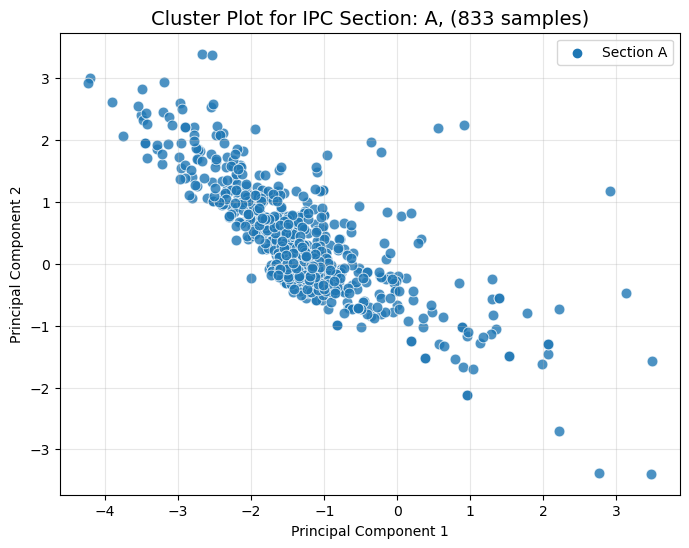

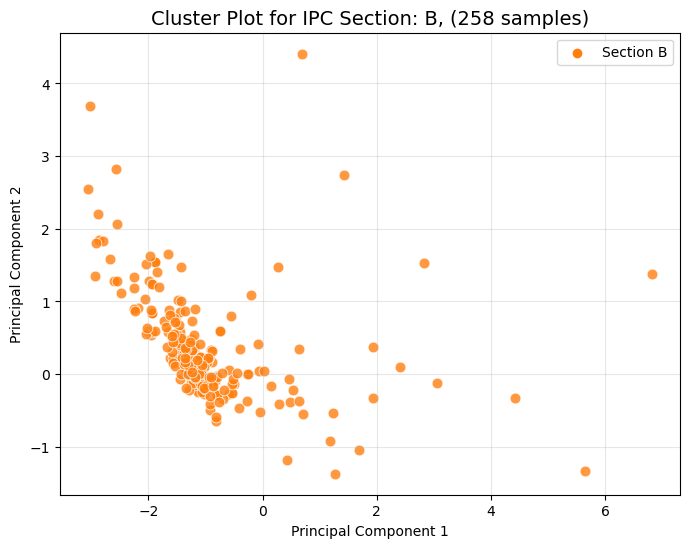

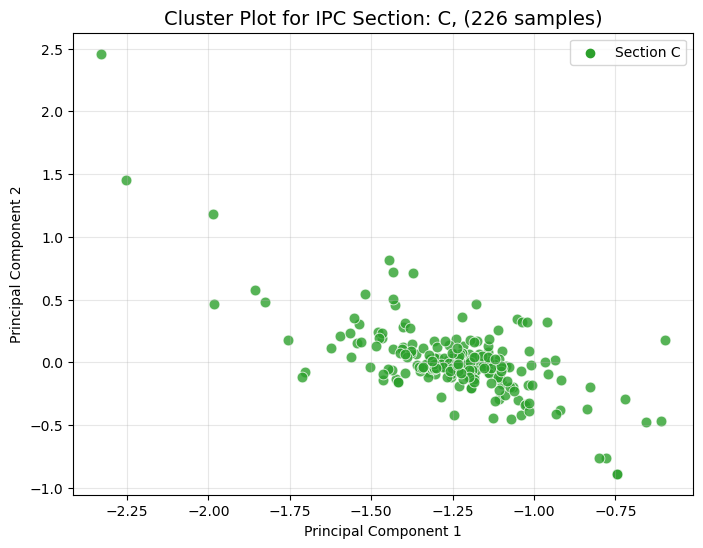

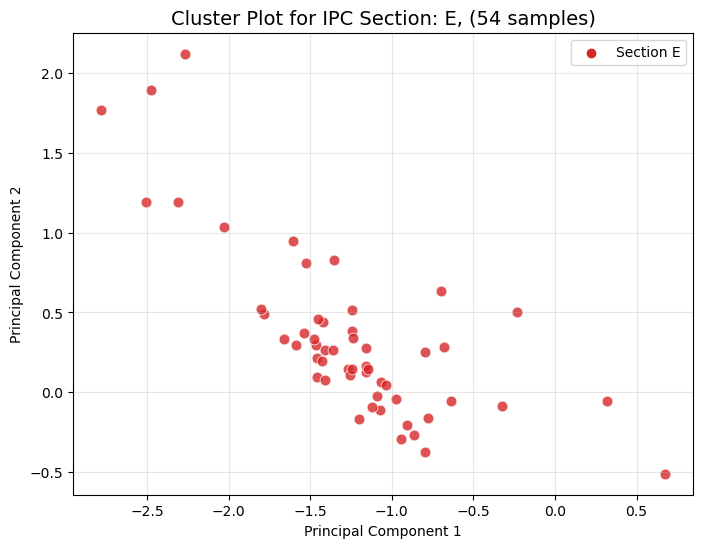

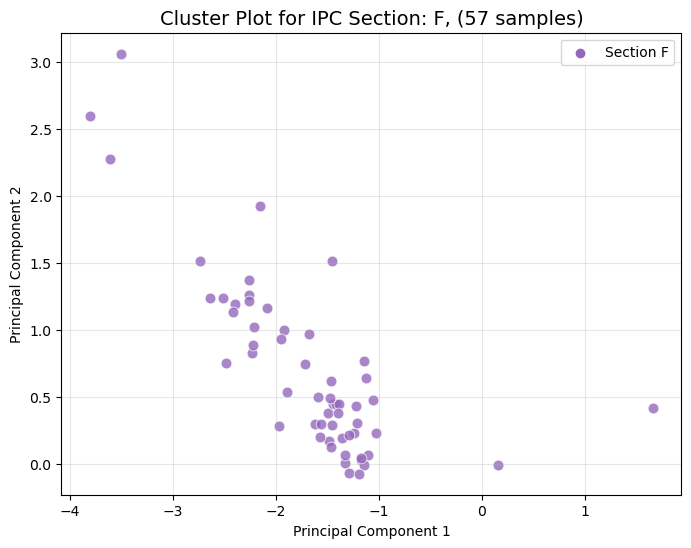

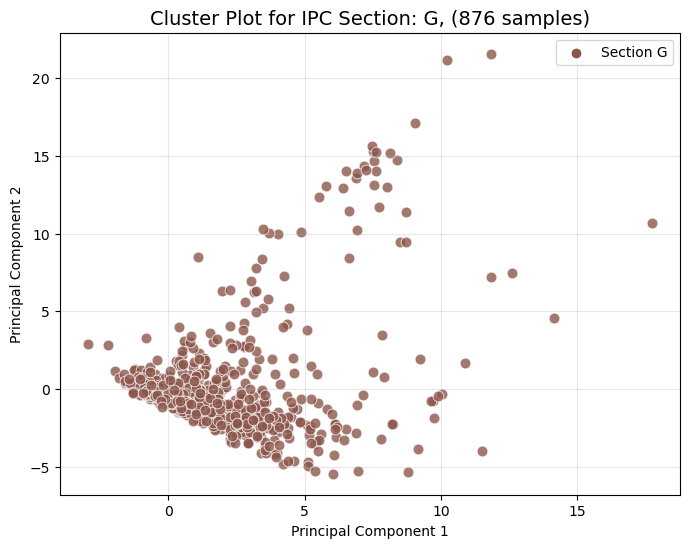

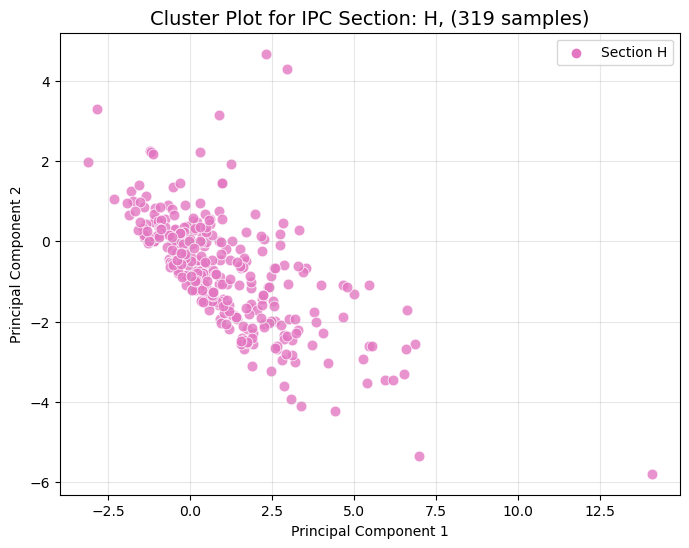

In [179]:
# now let's plot each section separately

unique_sections = sorted(pca_df["IPC_Section"].unique())
palette = sns.color_palette("tab10", len(unique_sections))
color_map = {sec: palette[i] for i, sec in enumerate(unique_sections)}

# 6. Plot each section separately using its assigned color
for section in unique_sections:
    pca_df_subset = pca_df[pca_df["IPC_Section"] == section]
    count = (pca_df_subset["IPC_Section"] == section).sum()
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=pca_df_subset, x="PC1", y="PC2", s=60, alpha=0.8, color=color_map[section]
    )

    plt.title(
        f"Cluster Plot for IPC Section: {section}, ({count} samples)",
        fontsize=14,
    )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True, alpha=0.3)

    # Show legend with single color
    plt.scatter([], [], color=color_map[section], label=f"Section {section}")
    plt.legend()

    plt.show()

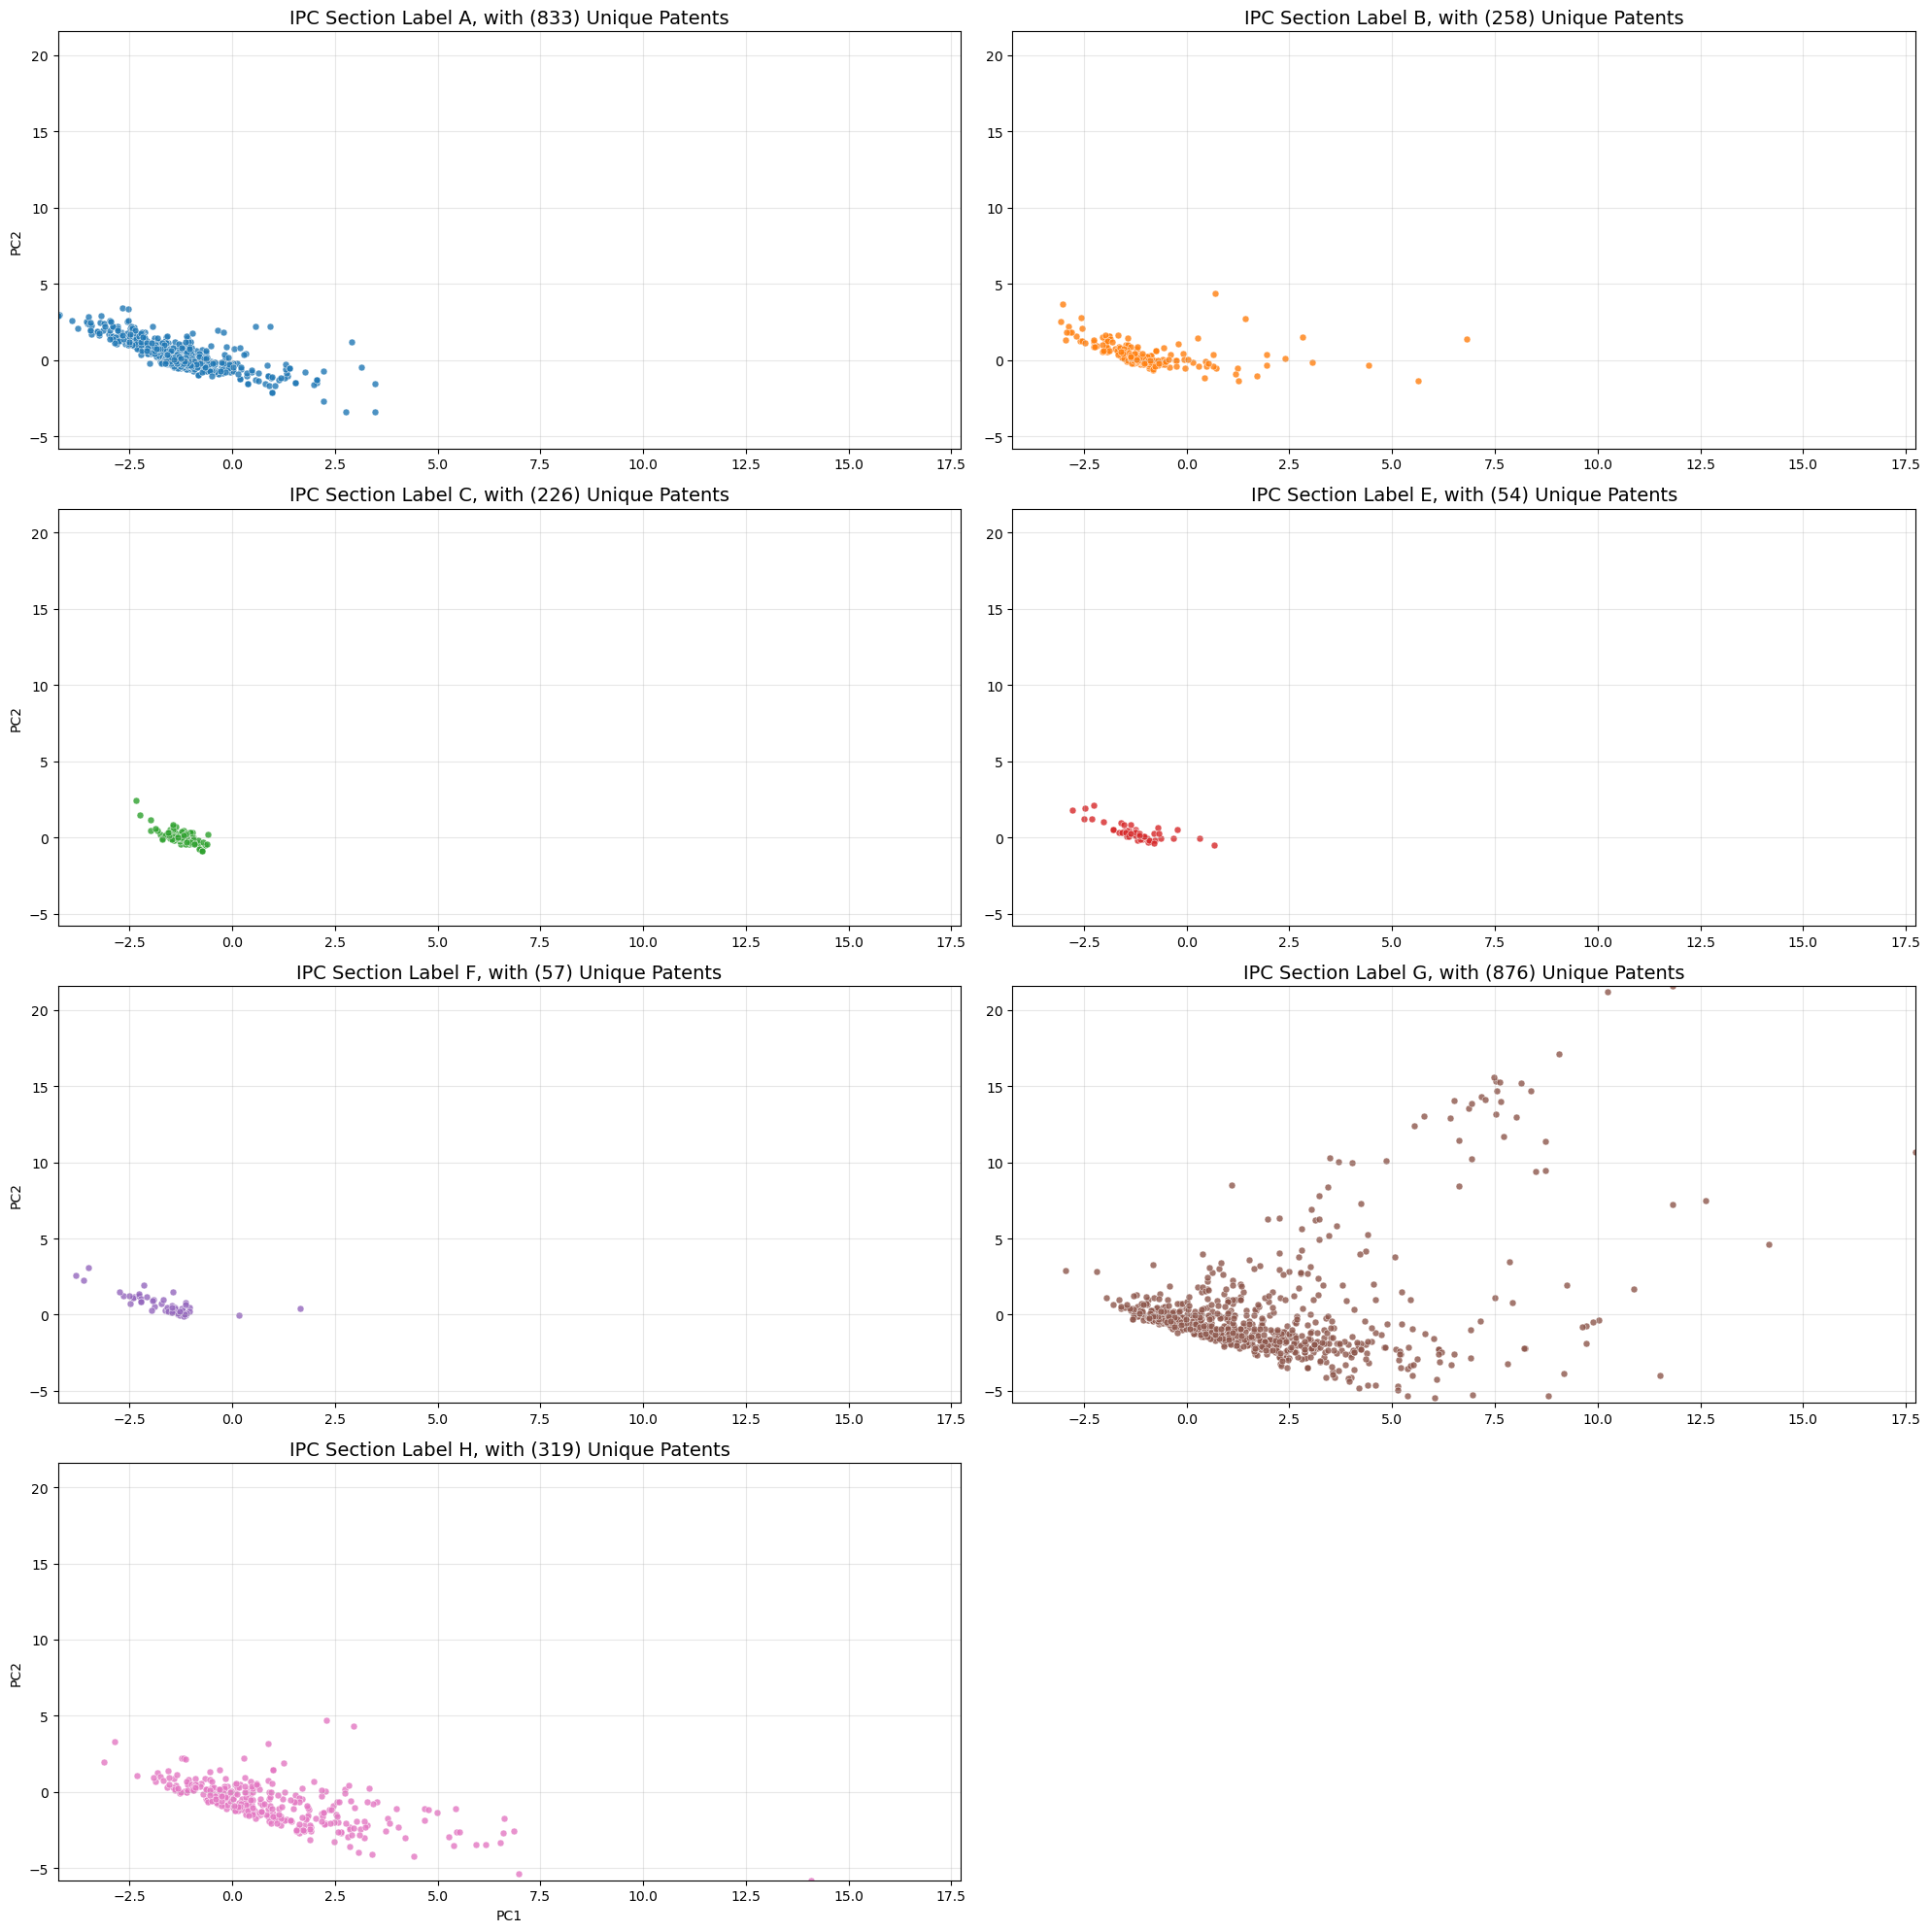

In [180]:
palette = sns.color_palette("tab10", len(unique_sections))
color_map = {sec: palette[i] for i, sec in enumerate(unique_sections)}

# Shared axes limits (FIXED: use pca_df, not df)
x_min, x_max = pca_df["PC1"].min(), pca_df["PC1"].max()
y_min, y_max = pca_df["PC2"].min(), pca_df["PC2"].max()

n = len(unique_sections)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, section in enumerate(unique_sections):
    ax = axes[i]
    # FIXED: use pca_df here
    df_sub = pca_df[pca_df["IPC_Section"] == section]

    sns.scatterplot(
        data=df_sub, x="PC1", y="PC2", s=25, alpha=0.8, color=color_map[section], ax=ax
    )

    ax.set_title(
        f"IPC Section Label {section}, with ({len(df_sub)}) Unique Patents", fontsize=14
    )
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(axis="both", which="both", labelbottom=True, labelleft=True)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Pros and Cons of the Solution:

**Complement Naive Bayes Classifier:**

The ComplementNB classifier was chosen because this variant of the Naive Bayes algorithm performs better on imbalanced datasets and text classification problems than the standard Multinomial Naive Bayes algorithm. This is important in contexts like patent classification, where IPC sections and labels for subsidiary patents appear much more frequently than others, or patents fall into multiple categories. The time difference between the two models was marginal in reality – The CNB model trained on real data took 0.0309 seconds compared to the SVC model’s 2.1687 second run time. However, if time is a crucial factor, the CNB model did outperform the SVC model in this metric. 

Some factors pose difficulties when using the ComplementNB classifier. Naive Bayes does not take into account word order, grammar rules, or common phrases. It treats input text simply like a bag of words and ignores human language rules. ComplementNB can only learn from words it has seen and is highly dependent on tokenization and preprocessing. The bag of words approach can hinder model performance, as evidenced by potential misclassifications where documents contain similar vocabulary but differ in technical function, resulting in the model grouping them into the same IPC class despite their conceptual differences. This is critical to patent classification because abstracts often contain domain-specific terms, which may be down-weighted if preprocessing doesn’t take it into account. In our model, this is evidenced by improved accuracy scores after iterations of data cleaning steps, including lemmatization and stop-word removal, which shows the model’s dependence on careful feature engineering. 

Finally, due to the “naive” nature of Naive Bayes models, they assume that the features are independent. Our real dataset of patent data appears to violate this assumption. CNB assumes that given the class the words occur independently, which is an incorrect assumption when handling real-world patent data. For data such as these, the SVC appears to learn the boundaries of the classes from the data in a better manner given it does not rely on this assumption. 


**Support Vector Classifier:**

Unlike ComplementNB (which relies on word count probabilities), LinearSVC focuses on finding decision boundaries that maximize separation between classes. This allows it to capture subtle differences in language and content, which is especially important for patent data, where many documents may contain similar words or word counts. For large patent corpora, LinearSVC often achieves higher overall accuracy than Naive Bayes because it can model more nuanced relationships in the data. However, training requires slightly more computation and careful handling of imbalanced data.

As LinearSVC is a discriminative model, it is less interpretable than ComplementNB; it does not provide probabilities for word importance, making it harder to explain why a patent was assigned to a particular IPC section. In addition to this, the LinearSVC can struggle with rare classes and imbalanced data, unless there is proper weighting or resampling methods. In general, it is more computationally expensive than ComplementNB, but for this project the difference in time was marginal. 

Therefore, because Naive Bayes ignores rules of a language but performs well in practice, it has high bias but low variance. In situations where the data is imbalanced or the text is significantly less domain-specific, we would recommend the use of the ComplementNB classifier over the support vector classifier model. LinearSVC is ideal when accuracy is critical and sufficient labeled patent data is available for each IPC section. 


**Comparing CountVectorizer to TF-IDF:**

For this iteration of our experiments, we replaced TF-IDF with CountVectorizer. CountVectorizer converts text into feature vectors by counting the frequency each word appears in an input document. TF-IDF counts word frequencies in a similar manner, but then applies a weighting scheme based on the rarity of the word in the corpus. Therefore words that appear frequently are down-weighted. 

When comparing this final report to our draft report, we see that the accuracy of the CNB model on real data is the same when using CountVectorizer (69% when using CountVectorizer and 69% when using TF-IDF) and the accuracy of the SVC model on real data is lower (72% when using CountVectorizer and 75% when using TF-IDF). We have not included tables from both reports for brevity, but the summary tables from our draft report are present in that Draft Report document). 

For practitioners interested in using SVC for text classification, we recommend using TF-IDF because SVC is helped by the weighting scheme of TF-IDF and the down-weighting this method utilizes. TF-IDF highlights rare and informative words because it does not down-weight them and keeps them at a higher weight, which helps SVC as a discriminative model. For practitioners that want to use CNB, CountVectorizer is the more appropriate approach because it does not use down-weighting and CNB already normalizes counts. CountVectorizer is better aligned with CNB’s assumptions that word counts follow a multinomial distribution. 


**Limitations:**

As acknowledged in the report, we attempted to reduce the overfitting for the learning curves with multiple methods, and for the synthetic data in particular, we could not find a strategy that worked. If repeating this project, we would recommend implementing a model or method better suited to imbalance data, like TruncatedSVD or SGDClassifier. TruncatedSVD modifies the model by reducing the word count matrix into smaller feature sets, which prevents the model from memorizing rare words. SGD classifier is a different linear model that uses gradient descent, which has better regularization and scale. Both methods would likely have an impact by lowering the training data accuracy and reducing overfitting. 


## Appendix

### Tables for Experiment with Synthetic Data

**Complement Naive Bayes Classifier**

In [181]:
from sklearn.metrics import classification_report

from tabulate import tabulate


# need this function to produce appendix output


def full_classification_table(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    report_dict = classification_report(y_test, preds, output_dict=True)

    report_df = pd.DataFrame(report_dict).transpose().round(4)

    return report_df

In [182]:
cnbs = ComplementNB()

report_syn_cnb = full_classification_table(
    cnbs, X_train_syn_vec, y_train_syn, X_test_syn_vec, y_test_syn
)


print("=== Synthetic Data — CNB Classification Report ===")

print(tabulate(report_syn_cnb, headers="keys", tablefmt="grid"))

=== Synthetic Data — CNB Classification Report ===
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| A;C_07;12;61 |      0      |   0      |     0      |     8     |
+--------------+-------------+----------+------------+-----------+
| A;C_07;61    |      0.2128 |   0.137  |     0.1667 |    73     |
+--------------+-------------+----------+------------+-----------+
| A;C_61;7     |      0.3226 |   0.1613 |     0.2151 |    62     |
+--------------+-------------+----------+------------+-----------+
| A;G_6;63     |      0      |   0      |     0      |    10     |
+--------------+-------------+----------+------------+-----------+
| A_23         |      0      |   0      |     0      |    10     |
+--------------+-------------+----------+------------+-----------+
| A_43         |      0.0833 |   0.0222 |     0.0351 |    45     |
+----------

**Support Vector Classifier**

In [183]:
svcs = LinearSVC()

report_syn_svc = full_classification_table(
    svcs, X_train_syn_vec, y_train_syn, X_test_syn_vec, y_test_syn
)


print("=== Synthetic Data — SVC Classification Report ===")

print(tabulate(report_syn_svc, headers="keys", tablefmt="grid"))

=== Synthetic Data — SVC Classification Report ===
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| A;C_07;12;61 |      0      |   0      |     0      |    8      |
+--------------+-------------+----------+------------+-----------+
| A;C_07;61    |      0.3043 |   0.2877 |     0.2958 |   73      |
+--------------+-------------+----------+------------+-----------+
| A;C_61;7     |      0.1569 |   0.129  |     0.1416 |   62      |
+--------------+-------------+----------+------------+-----------+
| A;G_6;63     |      0      |   0      |     0      |   10      |
+--------------+-------------+----------+------------+-----------+
| A_23         |      0      |   0      |     0      |   10      |
+--------------+-------------+----------+------------+-----------+
| A_43         |      0.1    |   0.0889 |     0.0941 |   45      |
+----------

### Tables for Experiment with Real Data

**Complement Naive Bayes Classifier**

In [184]:
print("Real Data Results (CountVectorizer):")
print(tabulate(report_df_real_cnb, headers="keys", tablefmt="grid"))

Real Data Results (CountVectorizer):
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| A;C_07;12;61 |      0      |   0      |     0      |   13      |
+--------------+-------------+----------+------------+-----------+
| A;C_07;61    |      0.4462 |   0.8447 |     0.5839 |  103      |
+--------------+-------------+----------+------------+-----------+
| A;C_61;7     |      0.7541 |   0.6301 |     0.6866 |   73      |
+--------------+-------------+----------+------------+-----------+
| A;G_6;63     |      0.5    |   0.0909 |     0.1538 |   11      |
+--------------+-------------+----------+------------+-----------+
| A_23         |      0.8333 |   0.8333 |     0.8333 |   12      |
+--------------+-------------+----------+------------+-----------+
| A_43         |      0.8475 |   0.9804 |     0.9091 |   51      |
+--------------+---------

**Support Vector Classifier**


In [185]:
print("Real Data Results - SVC (CountVectorizer):")
print(tabulate(report_df_real_svc, headers="keys", tablefmt="grid"))

Real Data Results - SVC (CountVectorizer):
+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| A;C_07;12;61 |      0.1667 |   0.2308 |     0.1935 |   13      |
+--------------+-------------+----------+------------+-----------+
| A;C_07;61    |      0.6068 |   0.6893 |     0.6455 |  103      |
+--------------+-------------+----------+------------+-----------+
| A;C_61;7     |      0.7024 |   0.8082 |     0.7516 |   73      |
+--------------+-------------+----------+------------+-----------+
| A;G_6;63     |      0.875  |   0.6364 |     0.7368 |   11      |
+--------------+-------------+----------+------------+-----------+
| A_23         |      0.9    |   0.75   |     0.8182 |   12      |
+--------------+-------------+----------+------------+-----------+
| A_43         |      0.8772 |   0.9804 |     0.9259 |   51      |
+--------------+---